In [1]:
from IPython.display import display, HTML
import pandas as pd
import sqlite3
from sqlite3 import Error
import time
from IPython.display import display, HTML
import pandas as pd
pd.options.mode.chained_assignment = None 
import sqlite3
from sqlite3 import Error
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from folium import Map
from folium.plugins import HeatMap


def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql, drop_table_name=None):
    
    if drop_table_name: # You can optionally pass drop_table_name to drop the table. 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows

In [2]:
# Create DB file

normalized_db = 'lightning_fire_normalized.db'
conn = create_connection(normalized_db, delete_db=True)

In [3]:
with open("US_Lightning_Forest_Fires.csv", "r") as file:
    all_rows = []
    while file.readline():
        line = file.readline()
        line = line.split(',')
        line_pruned = line[3:5] + line[6:-2]
        all_rows.append(line_pruned)

In [4]:
#Cleaning data

for k,j in enumerate(all_rows):
    if '' in j:
        all_rows.pop(k)


In [5]:
# Create FireDate Table

create_firedate_sql = """CREATE TABLE IF NOT EXISTS[FireDate](
                        [FireDateID] INTEGER NOT NULL PRIMARY KEY,
                        [FireDate] TEXT NOT NULL,
                        [FireMonth] INTEGER NOT NULL,
                        [FireYear] INTEGER NOT NULL)"""
create_table(conn, create_firedate_sql)
fire_date = []

for i in range(len(all_rows)):
    try:
        date = all_rows[i][0].split("-")
        count = 1
        if (all_rows[i][0], int(date[0]), int(date[2])) not in fire_date:
            fire_date.append((all_rows[i][0], int(date[0]), int(date[2])))
    except IndexError:
        pass

fire_date.sort(key=lambda x: time.mktime(time.strptime(x[0],"%m-%d-%Y")))
fire_date_insert_vals = [(i+1, fire_date[i][0], fire_date[i][1], fire_date[i][2]) for i in range(len(fire_date))]

def insert_firedate(conn, values):
    sql = '''INSERT OR IGNORE INTO FireDate(FireDateID, FireDate, FireMonth, FireYear)
        VALUES(?, ?, ?, ?)'''
    cur = conn.cursor()
    cur.executemany(sql, values)
    conn.commit()
    return cur.lastrowid

insert_firedate(conn, fire_date_insert_vals)

In [6]:
# Create fire_date dict

fire_date = {fire_date_insert_vals[i][1]: fire_date_insert_vals[i][0] for i in range(len(fire_date_insert_vals))}

In [7]:
state_name_map = {
  "AL": "Alabama",
  "AK": "Alaska",
  "AZ": "Arizona",
  "AR": "Arkansas",
  "CA": "California",
  "CO": "Colorado",
  "CT": "Connecticut",
  "DE": "Delaware",
  "DC": "District Of Columbia",
  "FL": "Florida",
  "GA": "Georgia",
  "HI": "Hawaii",
  "ID": "Idaho",
  "IL": "Illinois",
  "IN": "Indiana",
  "IA": "Iowa",
  "KS": "Kansas",
  "KY": "Kentucky",
  "LA": "Louisiana",
  "ME": "Maine",
  "MD": "Maryland",
  "MA": "Massachusetts",
  "MI": "Michigan",
  "MN": "Minnesota",
  "MS": "Mississippi",
  "MO": "Missouri",
  "MT": "Montana",
  "NE": "Nebraska",
  "NV": "Nevada",
  "NH": "New Hampshire",
  "NJ": "New Jersey",
  "NM": "New Mexico",
  "NY": "New York",
  "NC": "North Carolina",
  "ND": "North Dakota",
  "OH": "Ohio",
  "OK": "Oklahoma",
  "OR": "Oregon",
  "PA": "Pennsylvania",
  "RI": "Rhode Island",
  "SC": "South Carolina",
  "SD": "South Dakota",
  "TN": "Tennessee",
  "TX": "Texas",
  "UT": "Utah",
  "VT": "Vermont",
  "VA": "Virginia",
  "WA": "Washington",
  "WV": "West Virginia",
  "WI": "Wisconsin",
  "WY": "Wyoming"
}

def get_state_name(state_id):
    try:
        if state_id != 'PR':
            return state_name_map[state_id]
        elif state_id == 'PR':
            return 'Other States'
        else:
            pass
    except:
        pass

In [8]:
# Create FireState Table

create_firestate_sql = """CREATE TABLE IF NOT EXISTS[FireState](
                        [StateID] INTEGER NOT NULL PRIMARY KEY,
                        [State] TEXT NOT NULL,
                        [StateName] TEXT NOT NULL)"""
create_table(conn, create_firestate_sql)

fire_state = []
for i in range(len(all_rows)):
    try:
        if all_rows[i][-1] == "PR":
            all_rows.pop(i)
        if all_rows[i][-1] not in fire_state:
            fire_state.append(all_rows[i][-1])
    except IndexError:
        pass
    
fire_state.sort()

fire_state_insert_vals = [(i+1, fire_state[i], get_state_name(fire_state[i])) for i in range(len(fire_state))]

def insert_firestate(conn, values):
    sql = '''INSERT OR IGNORE INTO FireState(StateID, State, StateName)
        VALUES(?, ?, ?)'''
    cur = conn.cursor()
    cur.executemany(sql, values)
    conn.commit()
    return cur.lastrowid

insert_firestate(conn, fire_state_insert_vals)

In [9]:
# Create fire_state dict

fire_state = {fire_state_insert_vals[i][1]: fire_state_insert_vals[i][0] for i in range(len(fire_state_insert_vals))}

In [10]:
# Create FireDetails Table

create_details_sql = """CREATE TABLE IF NOT EXISTS[FireDetails](
                        [FireDetailsID] INTEGER NOT NULL PRIMARY KEY,
                        [FireDateID] INTEGER NOT NULL,
                        [DiscoveryTime] INTEGER NOT NULL,
                        [DaysToExt] INTEGER NOT NULL,
                        [ContTime] INTEGER NOT NULL,
                        [FireSize] REAL NOT NULL,
                        [FireClass] TEXT NOT NULL,
                        [Lattitude] TEXT NOT NULL,
                        [Longitude] TEXT NOT NULL,
                        [StateID] INTEGER NOT NULL,
                        FOREIGN KEY(FireDateID) REFERENCES FireDate(FireDateID),
                        FOREIGN KEY(StateID) REFERENCES FireState(StateID))"""


create_table(conn, create_details_sql)
fire_details = []


for index, line in enumerate(all_rows):
    try:

        days_to_ext = float(all_rows[index][2])
        cont_time = float(all_rows[index][3])
        fire_size = float(all_rows[index][4])
        fire_details.append((index, fire_date[all_rows[index][0]], float(all_rows[index][1]), 
                             days_to_ext, cont_time, fire_size, all_rows[index][5], all_rows[index][6], all_rows[index][7],
                             fire_state[all_rows[index][8]]))

    except:
        pass
fire_state_vals = []
for i in fire_details:
    fire_state_vals.append(i[9])
    

def unique(list1):
    unique_list = []
    for x in list1:
        if x not in unique_list:
            unique_list.append(x)
        
    return unique_list


def insert_firedet(conn, values):
    sql = ''' INSERT OR IGNORE INTO FireDetails(FireDetailsID, FireDateID, DiscoveryTime, DaysToExt,
            ContTime, FireSize, FireClass, Lattitude, Longitude, StateID)
              VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?, ?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    conn.commit()

insert_firedet(conn, fire_details)

In [11]:
normalized_database_filename = 'lightning_fire_normalized.db'
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
cur.execute("""select count(FireDateID) AS fire_count
                   from FireDate""")
rows = cur.fetchall()
fire_count = rows[0][0]

In [12]:
cur = conn.cursor()
cur.execute("""SELECT FireDate FROM FireDate ORDER BY FireDateID ASC LIMIT 1;""")
rows = cur.fetchall()
first_fire_date = rows[0][0]
cur.execute("""SELECT FireDate FROM FireDate ORDER BY FireDateID DESC LIMIT 1;""")
rows = cur.fetchall()
last_fire_date = rows[0][0]


from datetime import datetime
# Do last - first to get no of days
def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%m-%d-%Y")
    d2 = datetime.strptime(d2, "%m-%d-%Y")
    return abs((d2 - d1).days)

total_days = days_between(first_fire_date, last_fire_date)

# Pie chart representig the days of fire and no fire occured

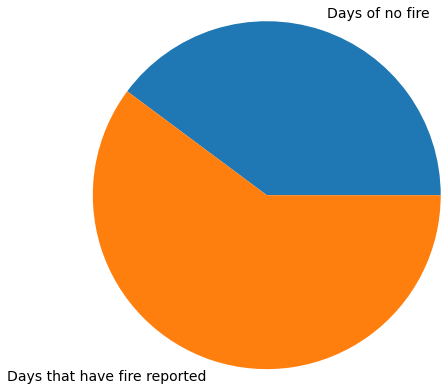

In [13]:
normalized_database_filename = 'lightning_fire_normalized.db'
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
cur.execute("""select count(FireDateID) AS fire_count
                   from FireDate""")
rows = cur.fetchall()
fire_count = rows[0][0]

cur = conn.cursor()

cur.execute("""SELECT FireDate FROM FireDate ORDER BY FireDateID ASC LIMIT 1;""")
rows = cur.fetchall()
first_fire_date = rows[0][0]
cur.execute("""SELECT FireDate FROM FireDate ORDER BY FireDateID DESC LIMIT 1;""")
rows = cur.fetchall()
last_fire_date = rows[0][0]


from datetime import datetime
# Do last - first to get no of days
def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%m-%d-%Y")
    d2 = datetime.strptime(d2, "%m-%d-%Y")
    return abs((d2 - d1).days)

total_days = days_between(first_fire_date, last_fire_date)

y = np.array([fire_count,total_days])
mylabels = ["Days of no fire", "Days that have fire reported"]

plt.pie(y, labels = mylabels, radius = 2, textprops={'fontsize': 14})
plt.show()


# Boxplots depecting the outliers identified. 


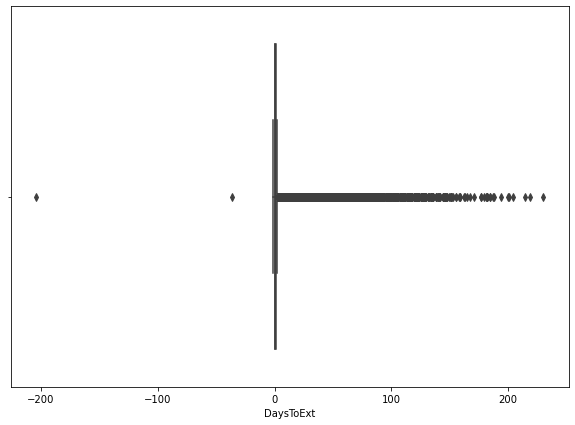

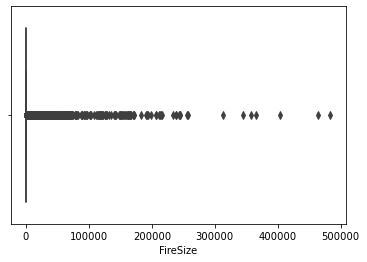

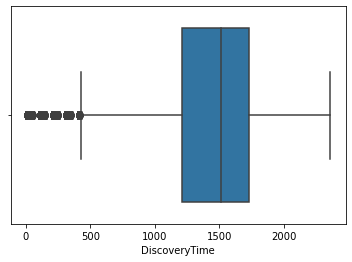

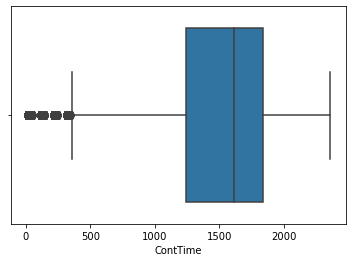

In [14]:
############ Boxplot of relevent columns ############
normalized_database_filename = 'lightning_fire_normalized.db'
conn = create_connection(normalized_database_filename)

state = pd.read_sql_query("""SELECT DaysToExt, FireSize, DiscoveryTime, ContTime  FROM FireDetails""", conn)
fig = plt.figure(figsize =(10, 7))
cont_train = state[['DaysToExt','FireSize','DiscoveryTime','ContTime']]
for i in cont_train:
    sns.boxplot(cont_train[i])
    plt.show()

# Boxplots for columns once outliers have been removed.

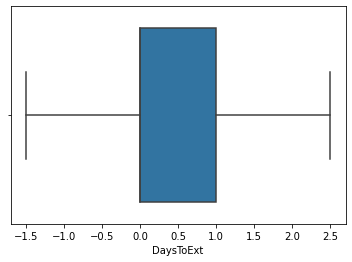

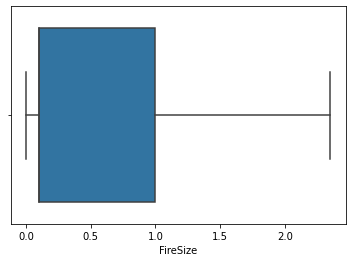

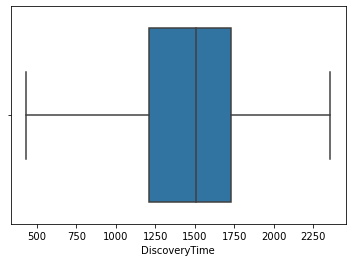

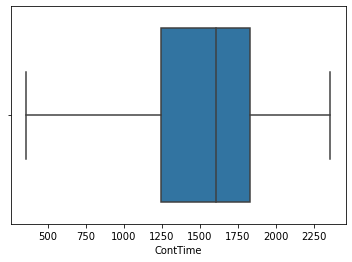

In [15]:
################ Removing outliers ###################
def remove_outlier(col):
    sorted(col)
    Q1,Q3=np.percentile(col,[25,75])
    IQR=Q3-Q1
    lower_range= Q1-(1.5 * IQR)
    upper_range= Q3+(1.5 * IQR)
    return lower_range, upper_range
for column in cont_train.columns:
    lr,ur=remove_outlier(cont_train[column])
    cont_train[column]=np.where(cont_train[column]>ur,ur,cont_train[column])
    cont_train[column]=np.where(cont_train[column]<lr,lr,cont_train[column])
for i in cont_train:
    sns.boxplot(cont_train[i])
    plt.show()

# Barplot for highest frequency of wildfire by state.

<AxesSubplot:xlabel='State', ylabel='FireSize'>

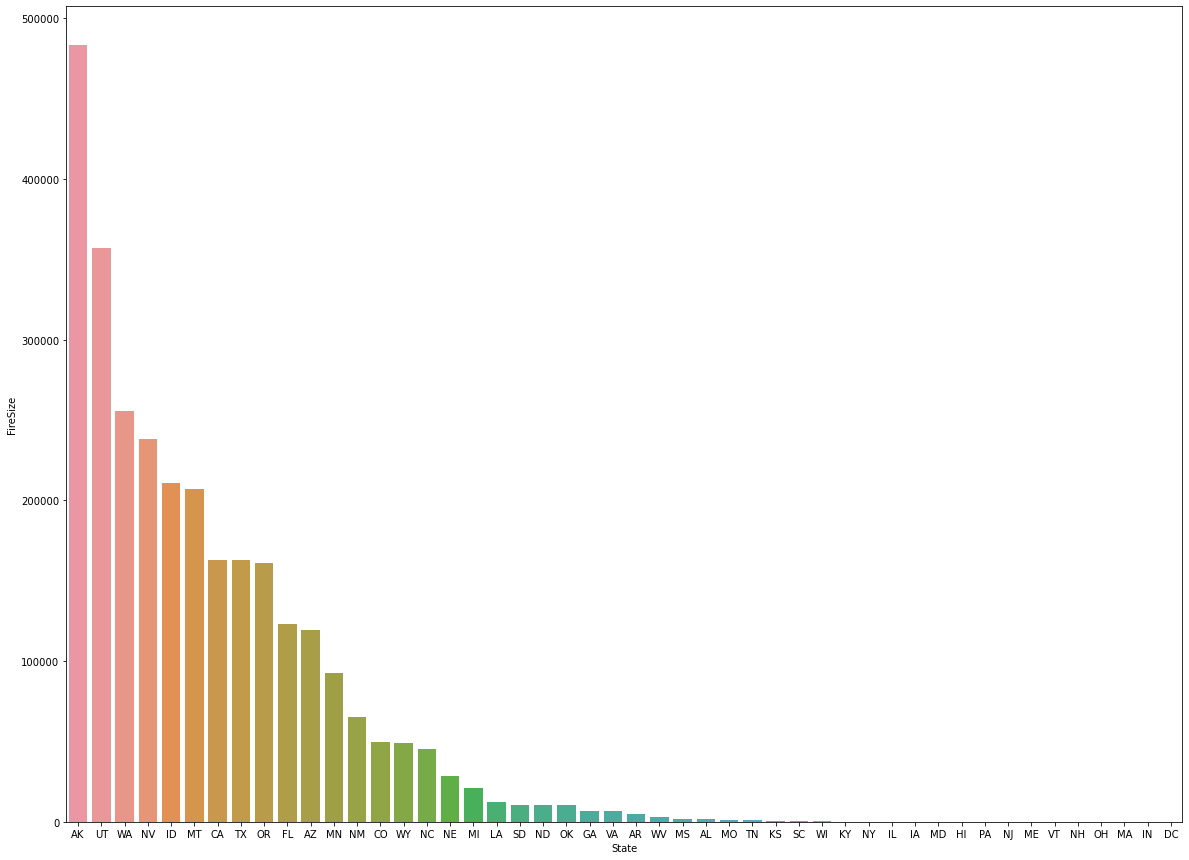

In [16]:
###########Barplot for Highest frequency of fire by state############
normalized_database_filename = 'lightning_fire_normalized.db'
conn = create_connection(normalized_database_filename)
state_f = pd.read_sql_query("""SELECT a.State, a.fs FireSize
from 
((select StateID, max(FireSize) as fs
from FireDetails 
group by StateID ) x
INNER join 
(SELECT State,StateID 
FROM FireState ) y
on x.StateID= y.StateID) a""", conn)

cur = conn.cursor()
fig, ax = plt.subplots(figsize = (20,15))
new_df = state_f.sort_values(by = 'FireSize',ascending=False)
sns.barplot(x = 'State',y = 'FireSize',ax = ax,data = new_df)

# Barplot showing frequency A B C D E F G wildfire size classes.

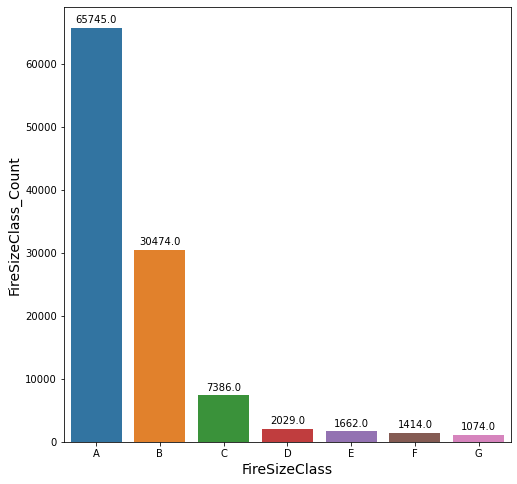

In [17]:
###########Barplot for frequency A B C D E F G ############
normalized_database_filename = 'lightning_fire_normalized.db'
conn = create_connection(normalized_database_filename)
fireclass_f = pd.read_sql_query("""SELECT FireClass, count(FireClass) as FireClass_Count 
from FireDetails
group by FireClass""", conn)

cur = conn.cursor()
new_df = fireclass_f.sort_values(by = 'FireClass_Count',ascending=False)
plt.figure(figsize=(8, 8))
 
# Defining the values for x-axis, y-axis
plots = sns.barplot(x="FireClass", y="FireClass_Count", data=new_df)
 
# Iterrating over the bars one-by-one
for bar in plots.patches:
    plots.annotate(format(bar.get_height()),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
 
 # Setting the label for x-axis
plt.xlabel("FireSizeClass", size=14)
 
# Setting the label for y-axis
plt.ylabel("FireSizeClass_Count", size=14)
 
# Finally showing the plot
plt.show()

# Geographical mapping of hotspots of wildfires. 

In [18]:
########### Hotspot for frequency ############
normalized_database_filename = 'lightning_fire_normalized.db'
conn = create_connection(normalized_database_filename)
hotspot_f = pd.read_sql_query("""SELECT  FireSize, Longitude, Lattitude
from FireDetails 
order by FireSize DESC 
LIMIT 15""", conn)
cur = conn.cursor()
data_map = Map(location=[57, -138], zoom_start=3.4, )
hm_wide = HeatMap(
    list(zip(hotspot_f.Lattitude.values, hotspot_f.Longitude.values)),
    min_opacity=0.2,
    radius=17, 
    blur=1,
    max_zoom=1,
)
data_map.add_child(hm_wide)

# Representation of count of wildfire across years.

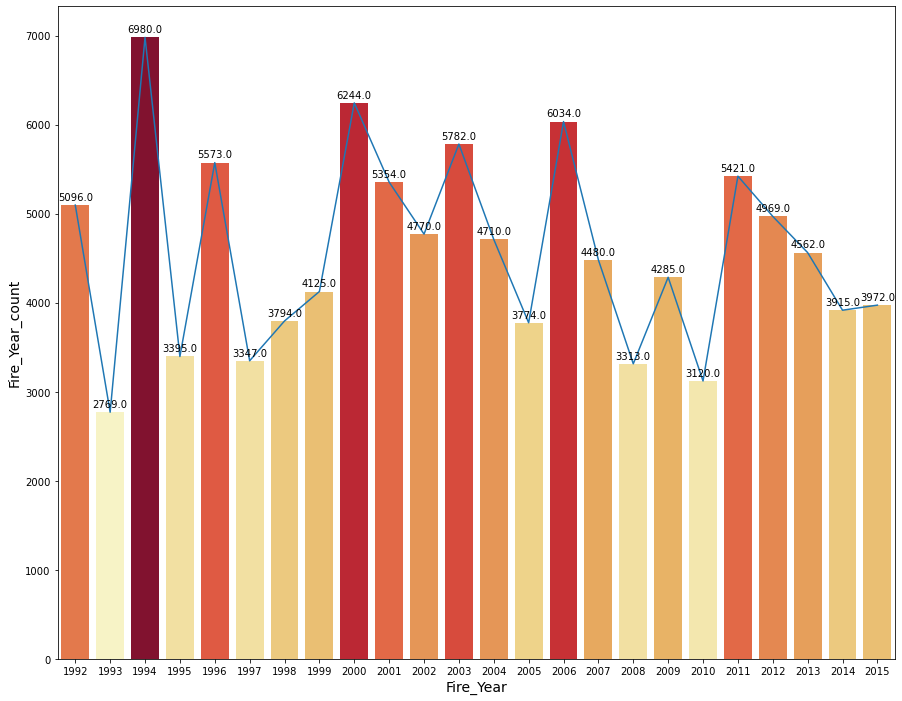

In [19]:
########### Count of fire across years ############
normalized_database_filename = 'lightning_fire_normalized.db'
conn = create_connection(normalized_database_filename)
fire_y = pd.read_sql_query("""
SELECT  Fire_Year, count(Fire_Year) as Fire_Year_count
FROM 
(SELECT fd2.FireSize, fd2.DaysToExt, fd2.FireClass, fd1.Fire_Year FROM
((SELECT  FireDateID, substr(FireDate, 7, 10) as Fire_Year
From FireDate) fd1
JOIN 
(SELECT * from FireDetails) fd2
on fd1.FireDateID = fd2.FireDateID) fd3)fd4
group by Fire_Year""", conn)

new_df = fire_y.sort_values(by = 'Fire_Year',ascending=True)
plt.figure(figsize=(15, 12))
 
# Defining the values for x-axis, y-axis
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

plots = sns.lineplot(x="Fire_Year", y="Fire_Year_count", data=new_df)
plots = sns.barplot(x="Fire_Year", y="Fire_Year_count", data=new_df, palette=colors_from_values(new_df.Fire_Year_count.values, "YlOrRd"))


# Iterrating over the bars one-by-one
for bar in plots.patches:
    plots.annotate(format(bar.get_height()),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
 
# Setting the label for x-axis
plt.xlabel("Fire_Year", size=14)
 
# Setting the label for y-axis
plt.ylabel("Fire_Year_count", size=14)
 
# Finally showing the plot
plt.show()

# Representation of days taken for extinguishing wildfire for E,F,G classes. 

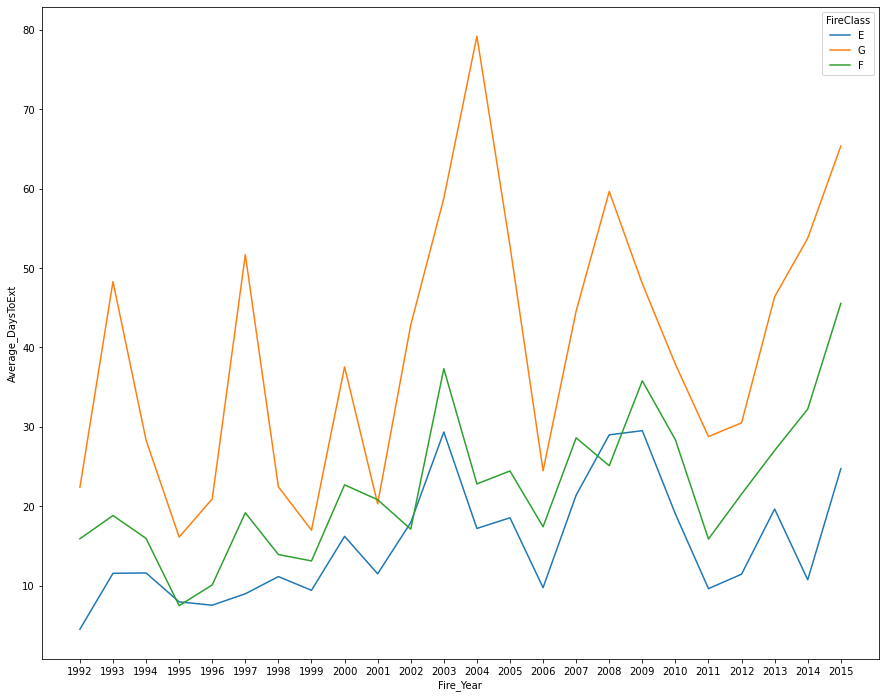

In [20]:
########### DaystoExt of FireClass E,F,G over the years ############
normalized_database_filename = 'lightning_fire_normalized.db'
conn = create_connection(normalized_database_filename)
fire_y = pd.read_sql_query("""
SELECT   FireClass , Fire_Year, Avg(DaysToExt ) as Average_DaysToExt
from 
(SELECT fd2.FireSize, fd2.DaysToExt, fd2.FireClass, fd1.Fire_Year FROM
((SELECT  FireDateID, substr(FireDate, 7, 10) as Fire_Year
From FireDate) fd1
JOIN 
(SELECT * from FireDetails where FireClass IN ("E" , "G" , "F")) fd2
on fd1.FireDateID = fd2.FireDateID) fd3)
group by 1, 2""", conn)

new_df = fire_y.sort_values(by = 'Fire_Year',ascending=True)
plt.figure(figsize=(15, 12))
sns.lineplot(data=new_df, x="Fire_Year", y="Average_DaysToExt", hue="FireClass")
plt.show()